<a href="https://colab.research.google.com/github/GabrielEliDias/LAPES-Data-Challenge-Predictive-Analytics-System/blob/feature%2Fmodeling/notebooks/02_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 🚀 Set up Colab environment
# Clone repo and install dependencies

!git clone https://github.com/GabrielEliDias/LAPES-Data-Challenge-Predictive-Analytics-System.git
!git checkout feature/modeling
%cd LAPES-Data-Challenge-Predictive-Analytics-System

# Install Python dependencies
!pip install -r requirements.txt




Cloning into 'LAPES-Data-Challenge-Predictive-Analytics-System'...
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 271 (delta 0), reused 3 (delta 0), pack-reused 266 (from 1)
Receiving objects: 100% (271/271), 417.28 KiB | 3.39 MiB/s, done.
Resolving deltas: 100% (128/128), done.
fatal: not a git repository (or any of the parent directories): .git
/content/LAPES-Data-Challenge-Predictive-Analytics-System
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 120.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [3]:
!git checkout feature/modeling

Branch 'feature/modeling' set up to track remote branch 'feature/modeling' from 'origin'.
Switched to a new branch 'feature/modeling'


In [4]:
!ls

Dockerfile  LICENSE  notebooks	README.md  requirements.txt  sql  src


In [22]:
!git branch

* feature/modeling
  main


In [7]:
# initial dataframe from the cleaned data in silver layer
import pandas as pd
from pathlib import Path

silver_path = Path.cwd() / 'data' / 'silver' / 'creditcard_fraud_cleaned.parquet'

df = pd.read_parquet(silver_path)
print(df.shape)
df.head(3)

(283726, 31)


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [8]:
# splitting dataset in X(independent features) and y (target class)

X = df.drop(columns='class')
y = df['class']
(y.value_counts()/y.shape[0])*100

,count
class,
0,99.83329
1,0.16671


In [9]:
# all the dataset is already scaled with pca transform, except for time and amount
# so before splitting and training the dataset,let's scale:
# time using minMaxscaler, which is standard
# amount using robustScaler, to better treat the significant rigth skewness and outliers

from sklearn.preprocessing import MinMaxScaler, RobustScaler
time_scaler = MinMaxScaler()
amount_scaler = RobustScaler()
X['time_scaled'] = time_scaler.fit_transform(X[['time']])
X['amount_scaled'] =amount_scaler.fit_transform(X[['amount']])
X[['amount_scaled','time_scaled']].describe()

,amount_scaled,time_scaled
count,283726.000000,283726.000000
mean,0.924387,0.548701
std,3.482123,0.274787
min,-0.305938,0.000000
25%,-0.228063,0.313699
50%,0.000000,0.490141
75%,0.771937,0.806160
max,356.962314,1.000000


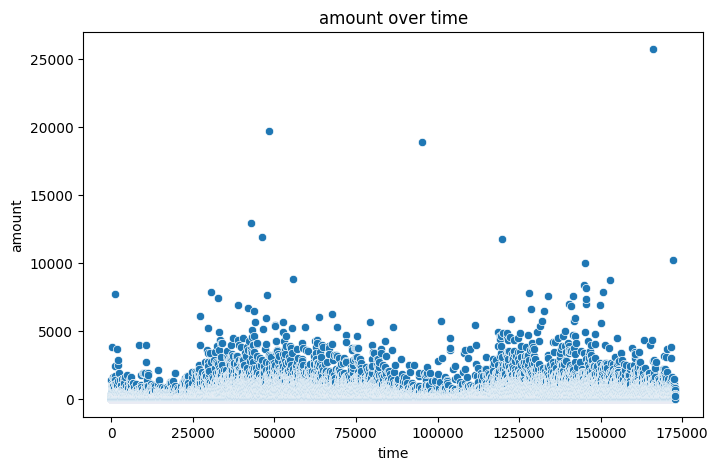

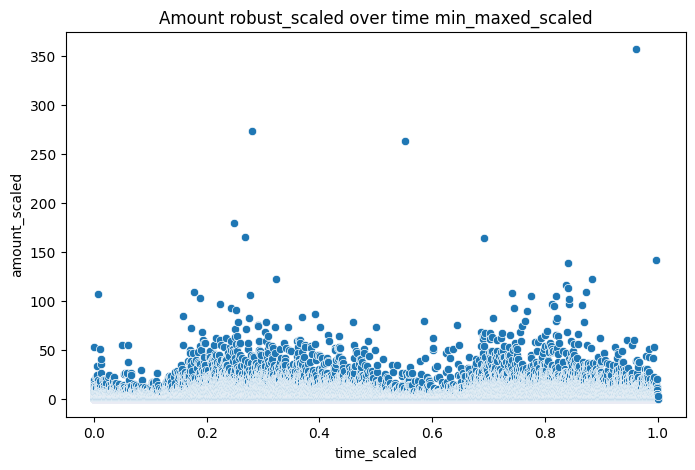

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
sns.scatterplot(data = X, x='time', y='amount')
plt.title('amount over time')
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data = X, x='time_scaled', y='amount_scaled')
plt.title('Amount robust_scaled over time min_maxed_scaled')
plt.show()


In [13]:
# splitting the data in training and testing, using stratify to keep the proportions and not bias the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

In [14]:
# lets check the data splitting (this could be a function in the ML pipeline) (still simillar proportion)
print('how many frauds and non frauds in the test split\n',y_train.value_counts())
print()
print((y_train.value_counts()/y_train.shape[0])*100)

how many frauds and non frauds in the test split
 class
0    226602
1       378
Name: count, dtype: int64

class
0    99.833466
1     0.166534
Name: count, dtype: float64


In [15]:
# as this is a binary classification problem (it has two classes, positive, fraud, and negative, non-fraud)
# a logistic classifier is more apropriate
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(class_weight='balanced',random_state=11037, max_iter=400)

In [16]:
# preparing the training data
X_train = X_train.drop(columns=['time','amount'])
X_train.head(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,time_scaled,amount_scaled
36303,1.275235,-0.890975,0.898017,-0.570927,-1.349695,-0.174539,-1.00894,-0.035709,-0.224417,0.450266,...,0.323601,0.924447,-0.231253,-0.031329,0.535375,-0.025224,0.044520,0.033308,0.223054,0.681407
110946,-1.374487,1.251974,2.027938,0.648848,-0.253916,-0.157952,0.28311,0.695574,-0.756486,-0.517604,...,-0.238922,-0.743726,-0.047144,0.394137,0.164834,0.656095,0.075993,0.040838,0.417896,-0.179530
159181,2.188293,-0.581739,-1.519878,-1.119704,-0.114288,-0.818030,-0.20486,-0.279319,-1.098546,0.996977,...,0.111044,0.226879,0.228523,0.785115,-0.055024,-0.373806,-0.052117,-0.062224,0.653717,-0.055764


## 🧠 Why Logistic Regression for the Baseline?
Logistic Regression is a simple, interpretable model that gives us a **baseline** for detecting fraud.
It's useful for benchmarking because:

- It requires minimal hyperparameter tuning.
- Its coefficients can indicate feature importance.
- However, **Logistic Regression is sensitive to feature scaling**, so we preprocess `time` and `amount`.

---

## ⚠️ Class Imbalance in Fraud Detection
The dataset is **highly imbalanced**:
- Class 0 (Non-Fraud): ~99.8%
- Class 1 (Fraud): ~0.2%

This means **accuracy** is a **bad metric** (a model predicting "no fraud" every time would still be right 99.8% of the time). Instead, we use metrics that focus on the minority class.

---

## 📏 Key Metrics for Imbalanced Data
| Metric            | Why It Matters                                                        |
|--------------------|------------------------------------------------------------------------|
| **Precision**      | Of all predicted fraud cases, how many were correct?                 |
| **Recall (Sensitivity)** | Of all actual fraud cases, how many did we detect?                  |
| **F1-score**       | Harmonic mean of Precision and Recall (balances false positives and negatives). |
| **ROC AUC**        | Measures model's ability to separate classes across thresholds.      |
| **PR AUC**         | Precision-Recall AUC focuses on the minority class (more informative for imbalanced data). |
| **Balanced Accuracy** | Adjusts accuracy to account for class imbalance.                  |

We’ll compute all of these using cross-validation.

In [17]:
# lets make predictions with cross validate and stratified k-fold
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import (
    make_scorer,
    precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
)

# define scorers
scoring = {
    'accuracy': 'accuracy',  # to show it does not properly reflect the model's efficiency
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc',
    'pr_auc': make_scorer(average_precision_score),  # PRAUC
    'balanced_accuracy': 'balanced_accuracy',
}

# stratified CV to preserve fraud/non-fraud ratio in all folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1103)

# perform cross-validation
cv_results = cross_validate(
    log_clf,
    X_train, y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False
)
results_df = pd.DataFrame(cv_results).mean(numeric_only=True)

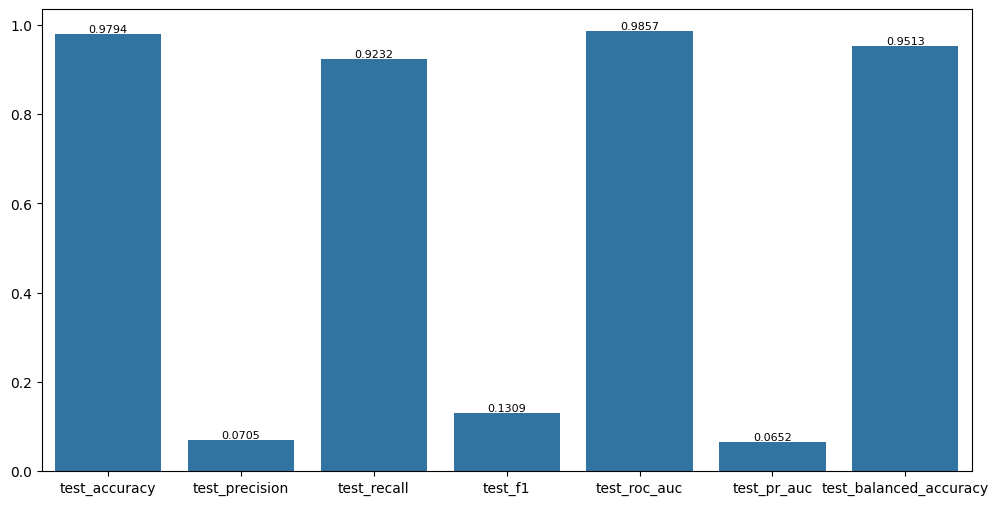

In [19]:
plt.figure(figsize=(12,6))
base_model_scores_barplot = sns.barplot(results_df.loc['test_accuracy':])


for patch in base_model_scores_barplot.patches:
    height = patch.get_height()
    if height > 0:
        base_model_scores_barplot.annotate(f'{height:.4f}',  # formatting
            (patch.get_x() + patch.get_width() / 2, height), # setting each coordinate to be on the patch
            ha='center', va='bottom', fontsize=8, rotation=0) # position related to the patch cordinate, right above and center


plt.show()

In [20]:
log_clf.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 400,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 11037,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [23]:
!git pull

remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 1.60 KiB | 136.00 KiB/s, done.
From https://github.com/GabrielEliDias/LAPES-Data-Challenge-Predictive-Analytics-System
   ce0ffa4..aa3374b  feature/modeling -> origin/feature/modeling
Updating ce0ffa4..aa3374b
Fast-forward
 notebooks/02_ml.ipynb | 53 ++++++++++++++++++---------------------------------
 1 file changed, 19 insertions(+), 34 deletions(-)
